In [1]:
import sys

import tensorflow as tf
import autokeras as ak
import pandas as pd

import matplotlib.pyplot as plt

sys.path.append("..")

from utils import paths

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tf.config.list_physical_devices()


2023-08-17 19:12:32.626627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 19:12:32.700498: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-17 19:12:32.703907: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-17 19:12:32.703919: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:
experiments = [
    "experiment_20230711_222446",  # 15 1024 16 1
    "experiment_20230711_222532",  # 15 32 32 1
    "experiment_20230711_222628",  # 15 256 128 1
    "experiment_20230711_222914",  # 15 32 64 1
    "experiment_20230711_223049",  # 15 256 16 32 1
]


In [3]:
data = pd.read_csv(paths.DATA_PATH + "/COVID19MX_sample.csv")
data = data.drop(columns=["TIPO_PACIENTE", "FECHA_INGRESO", "FECHA_SINTOMAS", "OTRA_COM",
                          "OTRO_CASO", "CLASIFICACION_FINAL", "PAIS_ORIGEN", "UCI"])

X = data.drop(columns=["DEFUNCION"]).to_numpy()
Y = data[["DEFUNCION"]].to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=557)


data.sample(10)


,SEXO,DEFUNCION,INTUBADO,NEUMONIA,EDAD,EMBARAZO,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,PAIS_NACIONALIDAD
22342,2,1,2.0,2.0,89.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,109.0
80318,2,0,3.0,2.0,54.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,109.0
67726,2,1,2.0,1.0,59.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,109.0
39243,1,1,2.0,2.0,77.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,109.0
67088,1,0,3.0,2.0,24.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,109.0
19874,1,0,3.0,2.0,23.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,109.0
49095,2,1,2.0,2.0,69.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,109.0
14288,1,1,2.0,2.0,74.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,109.0
81420,2,1,2.0,1.0,40.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,109.0
85467,2,0,3.0,2.0,20.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,109.0


585/585 [==============================] - 1s 740us/step


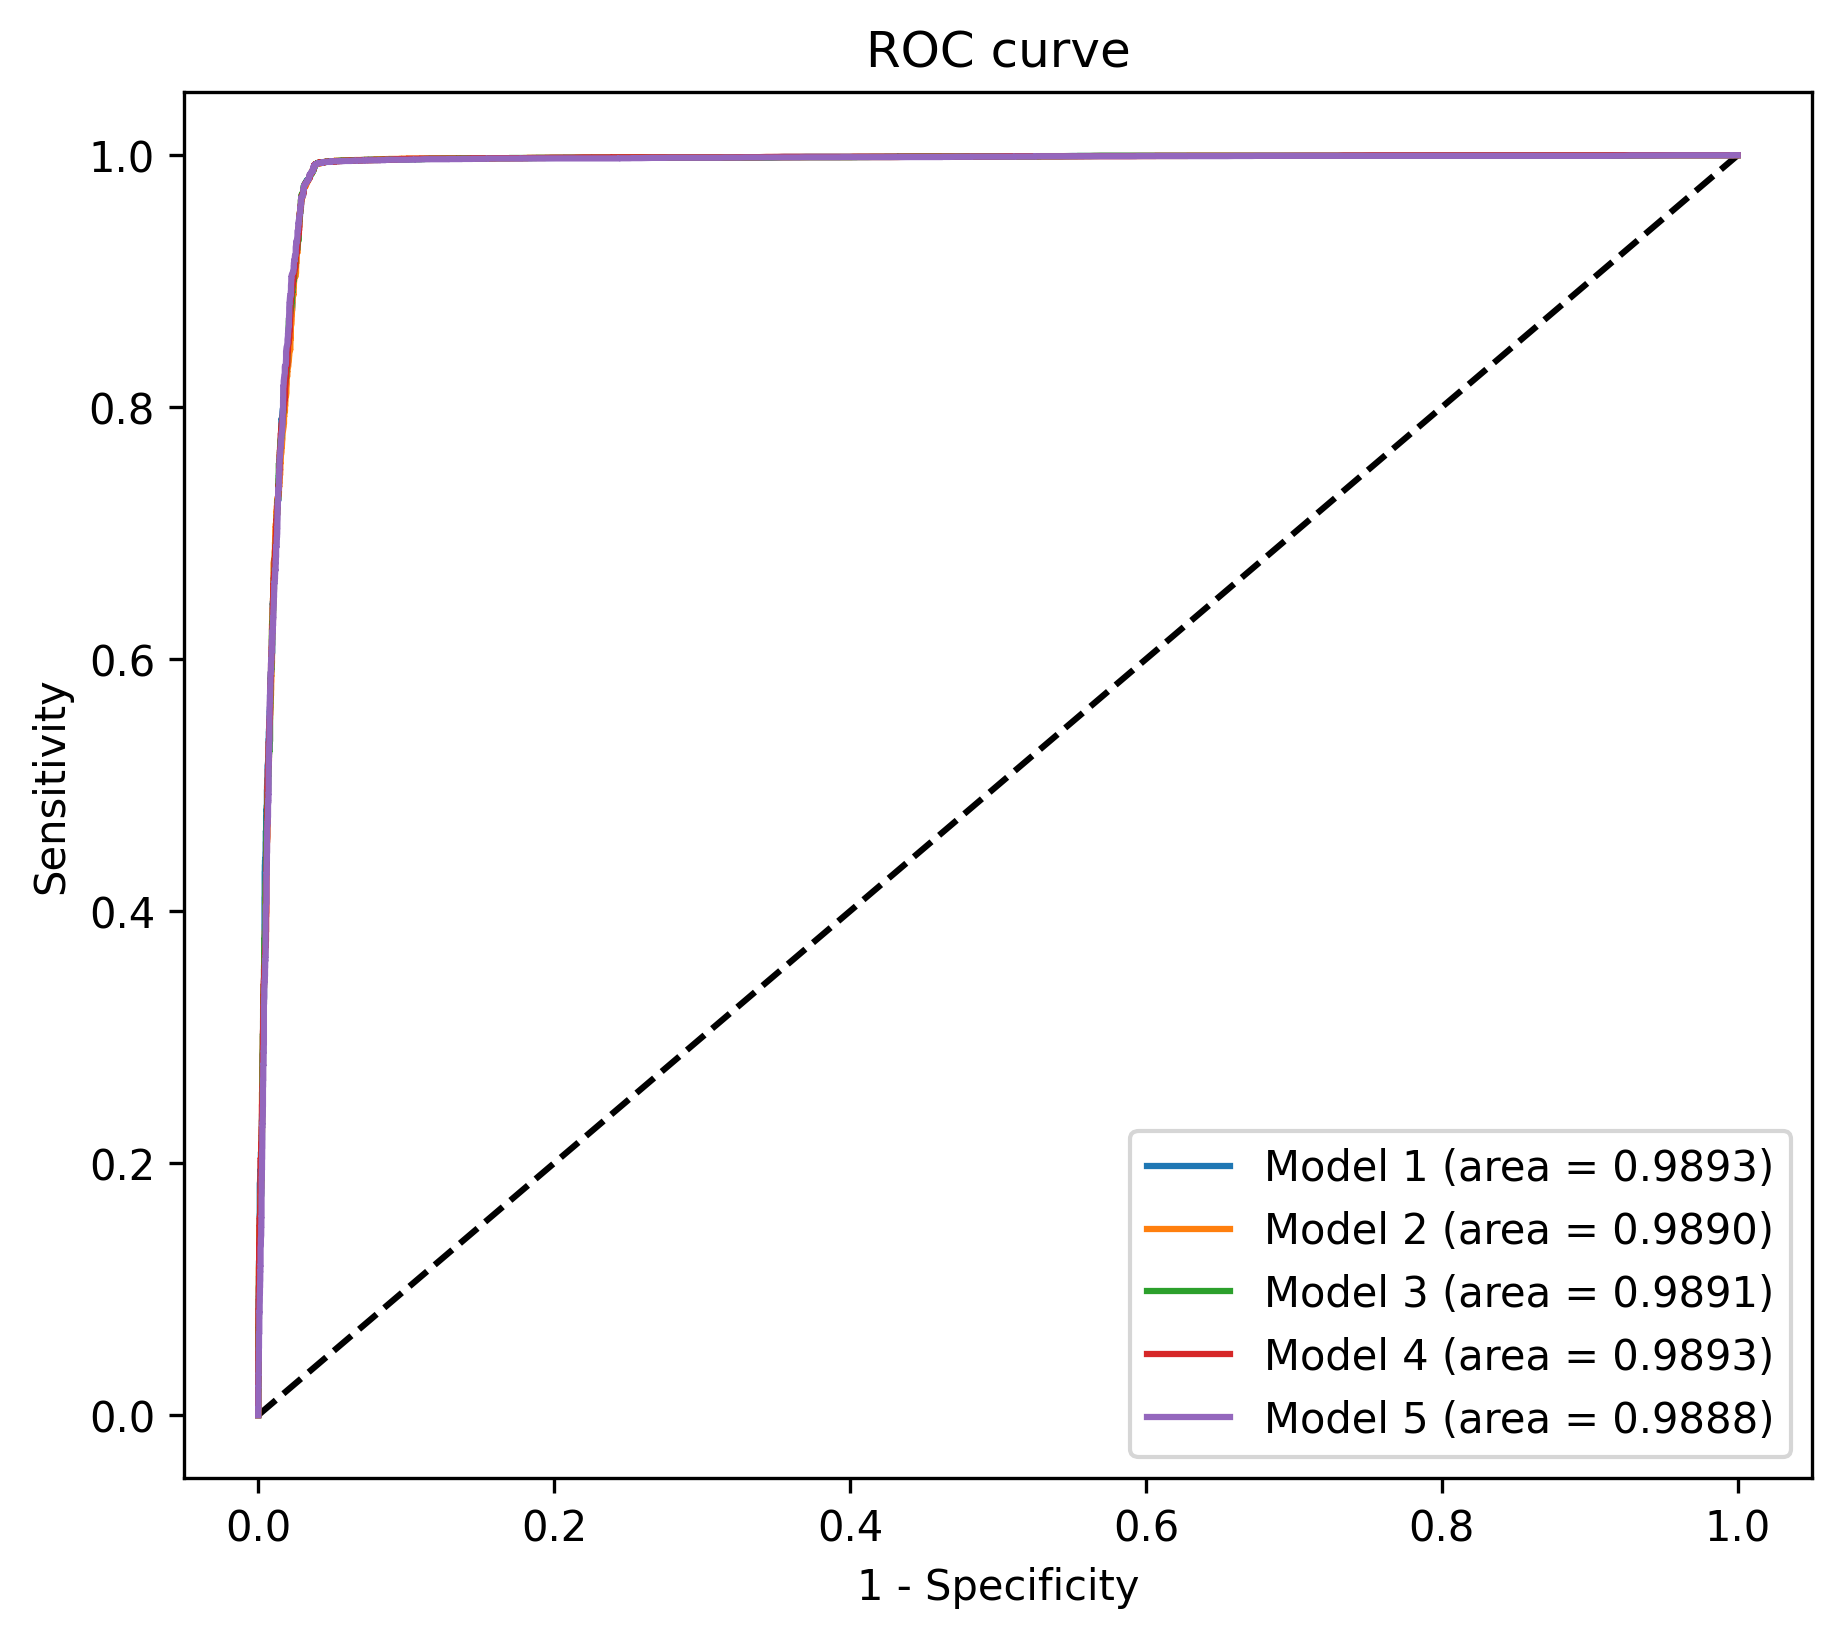

585/585 [==============================] - 0s 641us/step


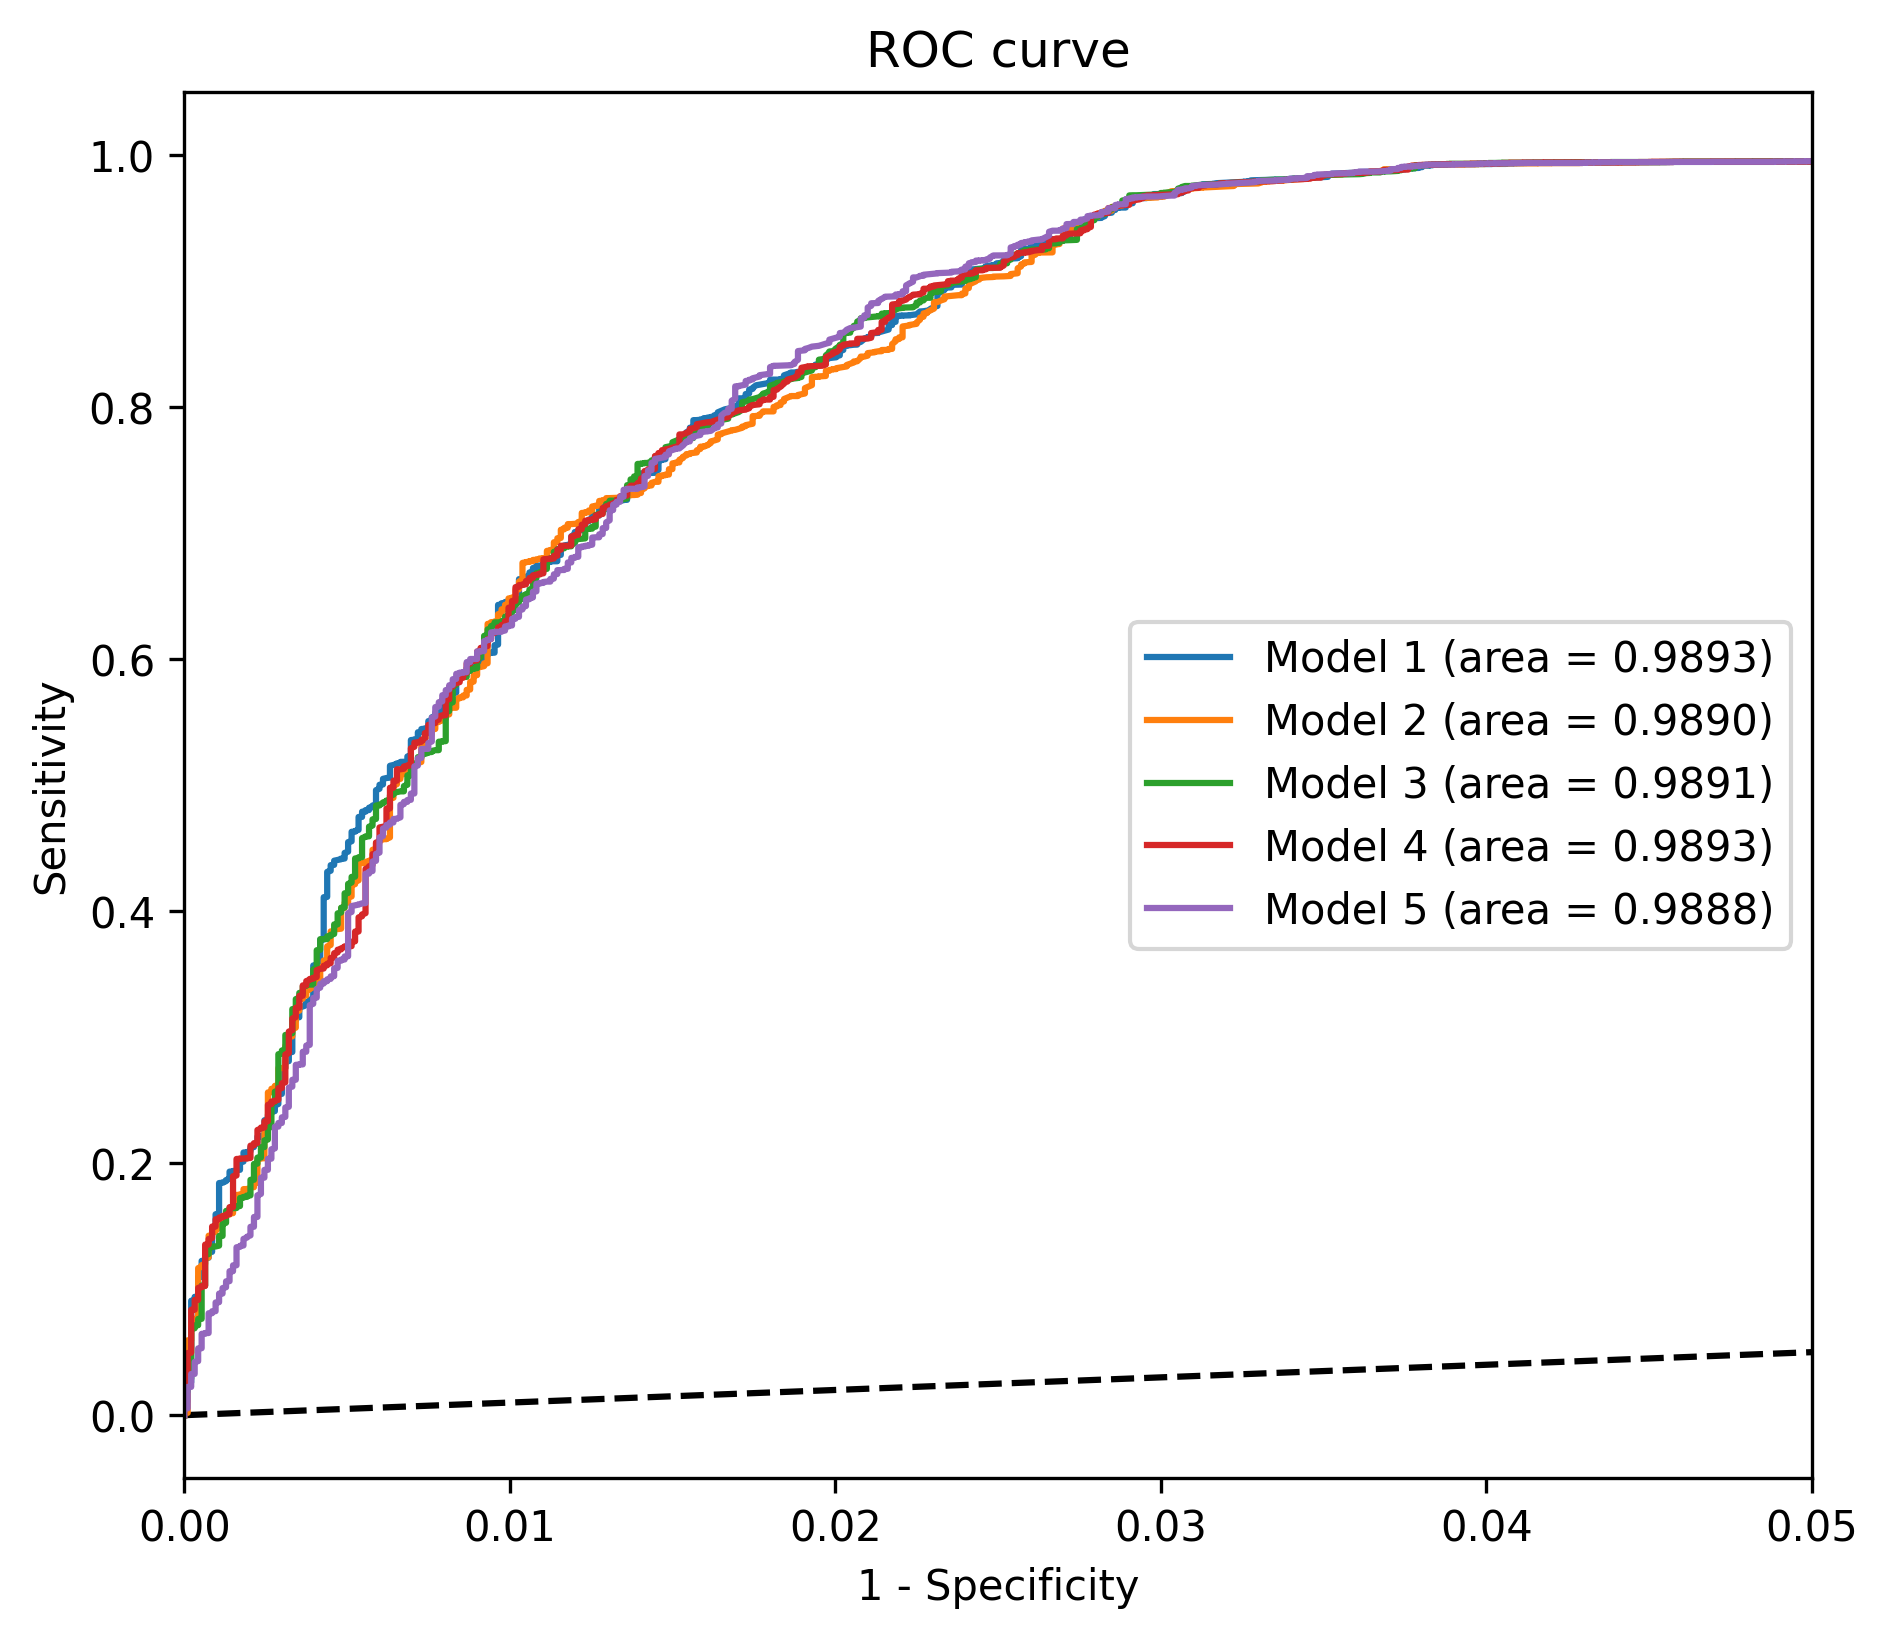

In [9]:
def plot_roc_curves(models, X_test, Y_test, xlim=None, sufix=""):
    fig = plt.figure(figsize=(7, 6), dpi=300)
    plt.plot([0, 1], [0, 1], 'k--')
    
    for idx, model_name in enumerate(models):
        model = tf.keras.models.load_model(f"{paths.MODELS_PATH}/{model_name}")
        y_pred_keras = model.predict(X_test).ravel()
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
        auc_keras = auc(fpr_keras, tpr_keras)
        # FPR = 1 - specificity --> 1 - FPR = specificity
        # TPR = sensitivity
        plt.plot(fpr_keras, tpr_keras, label='Model {} (area = {:.4f})'.format(idx+1, auc_keras))

    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC curve')
    if xlim:
        plt.xlim(xlim)
    plt.legend(loc='best')
    plt.savefig(f"{paths.FIGURES_PATH}/roc_curves{sufix}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{paths.FIGURES_PATH}/roc_curves{sufix}.tif", dpi=300)
    plt.show()

plot_roc_curves(experiments, X_test, Y_test)
plot_roc_curves(experiments, X_test, Y_test, xlim=[0, 0.05], sufix="_zoom")


In [5]:
# Load K-Fold result
accuracy = pd.read_csv(paths.RESULTS_PATH + "/kfold/accuracy_results.csv")[["model", "mean"]]
f1_score = pd.read_csv(paths.RESULTS_PATH + "/kfold/f1_score_results.csv")[["model", "mean"]]
precision = pd.read_csv(paths.RESULTS_PATH + "/kfold/precision_results.csv")[["model", "mean"]]
sensitivity = pd.read_csv(paths.RESULTS_PATH + "/kfold/sensitivity_results.csv")[["model", "mean"]]
specificity = pd.read_csv(paths.RESULTS_PATH + "/kfold/specificity_results.csv")[["model", "mean"]]
results = [accuracy, f1_score, precision, sensitivity, specificity]


In [6]:
model_1 = [result.loc[0]["mean"] for result in results]
model_2 = [result.loc[1]["mean"] for result in results]
model_3 = [result.loc[2]["mean"] for result in results]
model_4 = [result.loc[3]["mean"] for result in results]
model_5 = [result.loc[4]["mean"] for result in results]

print(f"{model_1}\n{model_2}\n{model_3}\n{model_4}\n{model_5}")


[0.9768029153347016, 0.9771702826424594, 0.963133699038121, 0.9916221414832228, 0.963133699038121]
[0.9769313216209412, 0.9773076518009968, 0.9628162608042782, 0.99224193203676, 0.9628162608042782]
[0.9770222663879394, 0.9773984182998694, 0.9628516540711118, 0.9923915366531312, 0.9628516540711118]
[0.9768778145313264, 0.9772526259518164, 0.962860443526234, 0.9920816413763625, 0.962860443526234]
[0.9769473671913148, 0.977324174998115, 0.9627982379777968, 0.9922953622568926, 0.9627982379777968]


In [7]:
# Realizar el ANOVA
anova_results = f_oneway(model_1, model_2, model_3, model_4, model_5)
print(f"p-valor: {anova_results.pvalue:.4f}")

# Si el p-valor es significativo (p < 0.05), procede al post-hoc Tukey
if anova_results.pvalue < 0.05:
    # Convertir los datos en un formato adecuado para el post-hoc Tukey
    stacked_data = data.melt(var_name='Arquitectura', value_name='Métrica')

    # Realizar el post-hoc Tukey
    tukey_results = pairwise_tukeyhsd(stacked_data['Métrica'], stacked_data['Arquitectura'])
    print(tukey_results)
else:
    print("No se encontraron diferencias significativas entre grupos.")


p-valor: 1.0000
No se encontraron diferencias significativas entre grupos.
